<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/05-Time_Series/B-ERCOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing electricity usage from Electric Reliability Council of Texas (ERCOT)

ERCOT releases the electricity usage of their grid at http://www.ercot.com/gridinfo/load

The archives are at: http://www.ercot.com/gridinfo/load/load_hist

ERCOT also publishes their own load forecasts, this is a good baseline for any model.

In [1]:
!sudo apt-get install unzip
!pip install -U pip
!pip install -U statsmodels xlrd PyMySQL sqlalchemy sql_magic prophet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

In [4]:
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine

# Load and plot the data


In [5]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    password = 'dwdstudent2015', 
    db = 'ercot',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

# This query loads the dataset from the DB into the dataframe 
df = pd.read_sql("SELECT * FROM ercot.electricity", con=con)
df = df.set_index('DATE_TIME')

con.close()

In [6]:

df

COAST         EAST        FWEST       NORTH  \
DATE_TIME                                                                 
2002-01-01 01:00:00   8331.469266  1111.096549  1094.045496  995.298392   
2002-01-01 02:00:00   8107.805431  1091.481584  1083.517981  981.195477   
2002-01-01 03:00:00   7890.721717  1080.257616  1085.038740  971.305257   
2002-01-01 04:00:00   7799.817527  1079.726403  1093.381853  971.262963   
2002-01-01 05:00:00   7815.968171  1087.934961  1106.651296  982.535591   
...                           ...          ...          ...         ...   
2021-12-31 20:00:00  13926.775034  1566.583851  4192.977787  916.124441   
2021-12-31 21:00:00  13498.908542  1549.687559  4149.062209  886.943872   
2021-12-31 22:00:00  13116.012129  1515.852644  4148.330779  859.408149   
2021-12-31 23:00:00  12754.392799  1457.080439  4161.355505  831.148872   
2022-01-01 00:00:00  12386.413060  1415.239264  4119.738722  807.084492   

                            NCENT        SOUTH        SCENT         WEST  \
DATE_TIME                                                                  
2002-01-01 01:00:00  10336.304899  2165.007571  4793.193560   843.747177   
2002-01-01 02:00:00  10178.052738  2092.374118  4766.918187   835.488188   
2002-01-01 03:00:00  10100.887710  2042.080714  4702.918892   830.694878   
2002-01-01 04:00:00  10081.565109  2011.935791  4669.064391   835.068413   
2002-01-01 05:00:00  10192.218670  2002.487678  4695.011904   848.598209   
...                           ...          ...          ...          ...   
2021-12-31 20:00:00  11942.416165  3910.031058  7401.098687  1133.093917   
2021-12-31 21:00:00  11406.911057  3681.222926  7088.478765  1102.727285   
2021-12-31 22:00:00  10978.547227  3515.077507  6800.707246  1071.686005   
2021-12-31 23:00:00  10578.729201  3368.125857  6497.990404  1049.414195   
2022-01-01 00:00:00  10140.379573  3234.113244  6151.440423  1016.183096   

                            ERCOT  
DATE_TIME                          
2002-01-01 01:00:00  29670.162911  
2002-01-01 02:00:00  29136.833703  
2002-01-01 03:00:00  28703.905525  
2002-01-01 04:00:00  28541.822450  
2002-01-01 05:00:00  28731.406478  
...                           ...  
2021-12-31 20:00:00  44989.100940  
2021-12-31 21:00:00  43363.942215  
2021-12-31 22:00:00  42005.621687  
2021-12-31 23:00:00  40698.237272  
2022-01-01 00:00:00  39270.591873  

[175320 rows x 9 columns]

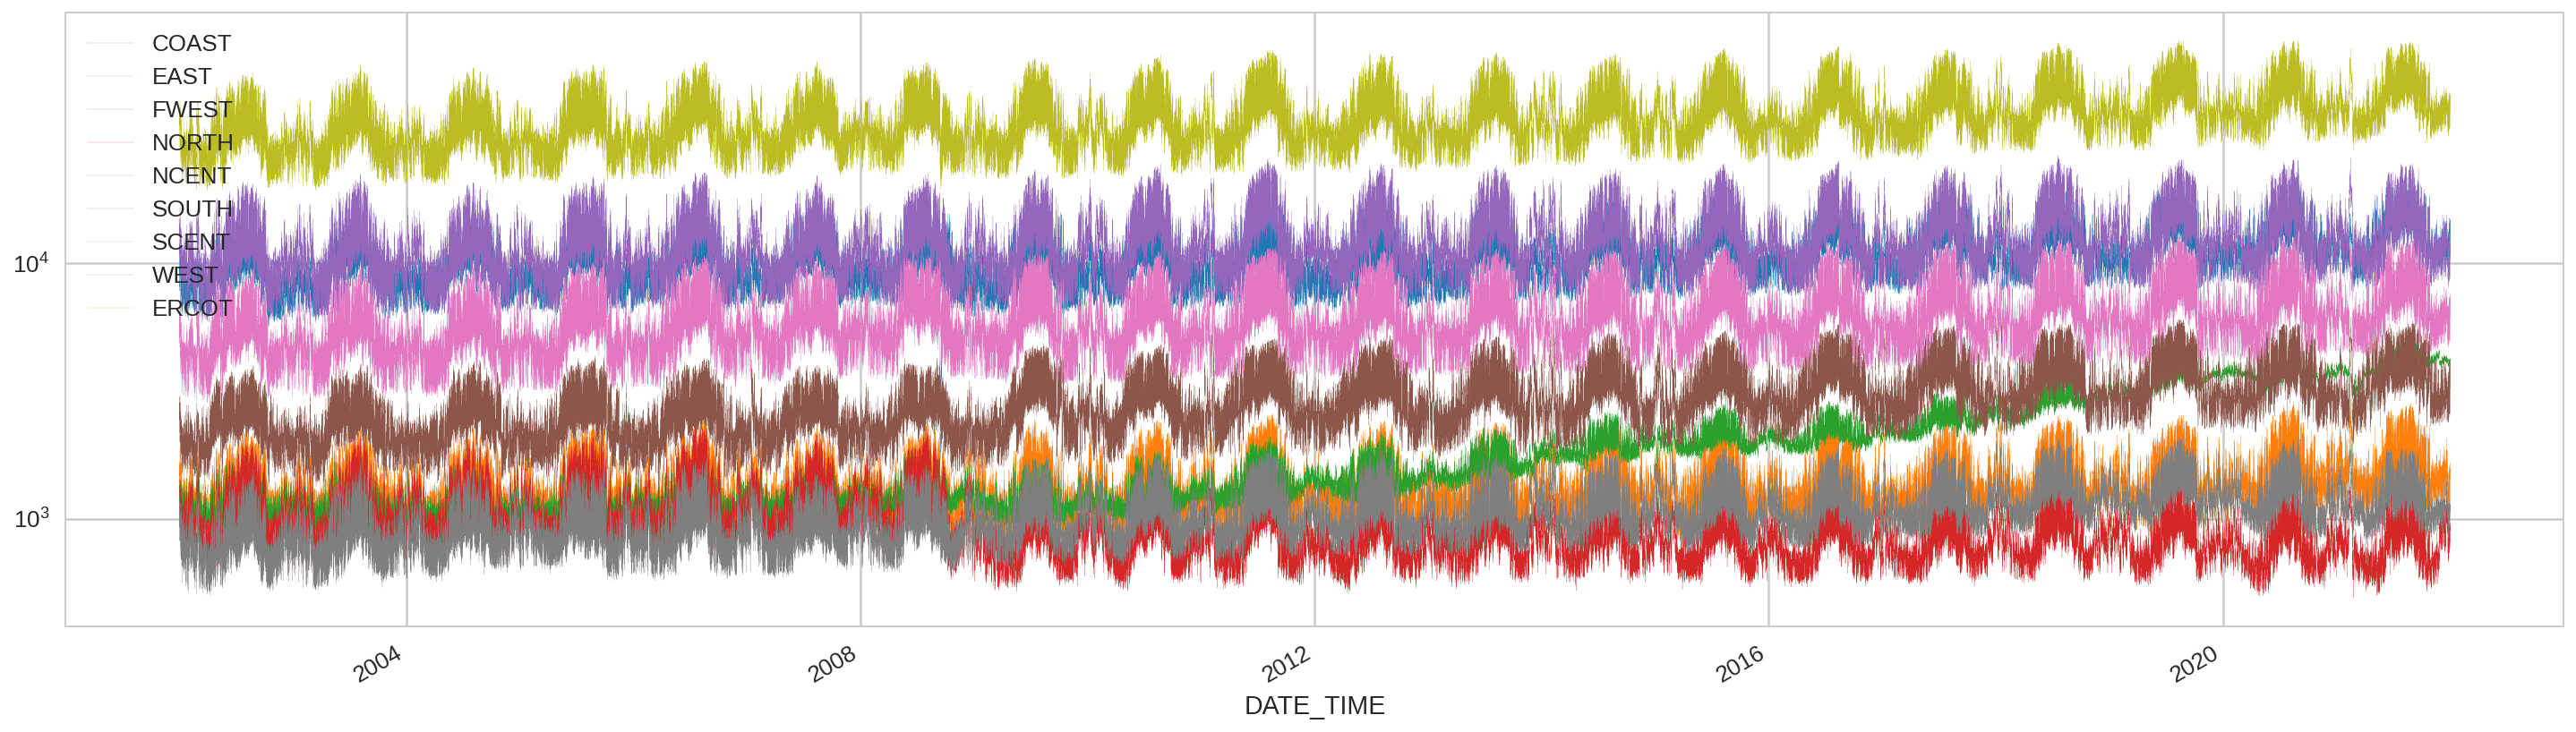

In [7]:
df.plot(figsize=(25,7), linewidth=0.1, logy=True)

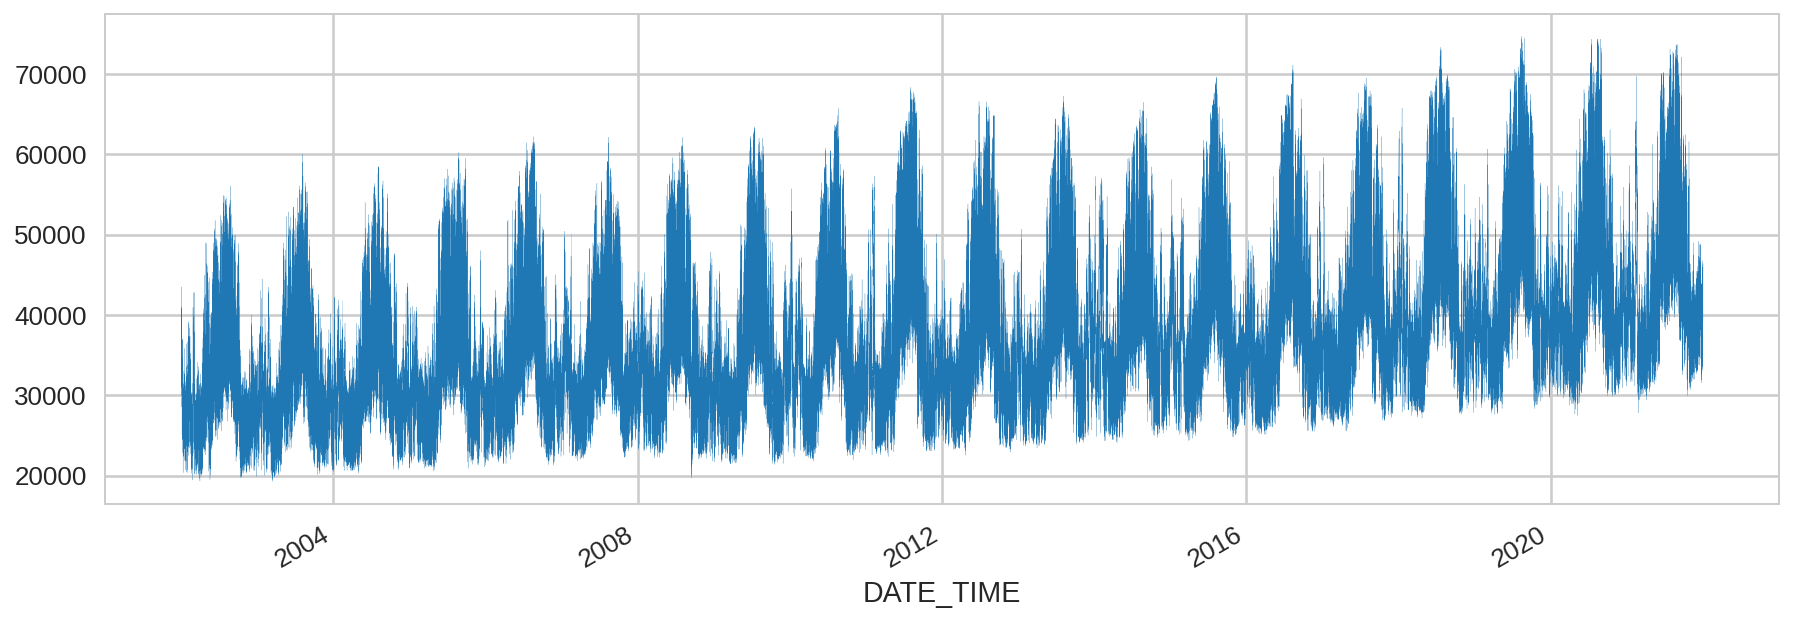

In [8]:
df.ERCOT.plot(linewidth=0.1, figsize=(15,5))


# The basics

* Resample and calculate yearly, monthly, etc components
* Talk about moving averages instead of fixed period averages. Introduce the rolling windows
* Different window shapes, plus exponential averaging

## Extracting Time Series Components: Trend, Seasonal, Residual 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + R[t]
# The multiplicative model is Y[t] = T[t] * S[t] * R[t]

### Extracting Yearly Components

In [10]:
Y = df.ERCOT

decompose = seasonal_decompose(Y, 
                                model='multiplicative', 
                                period=24, 
                                extrapolate_trend='freq')

T_d, S_d, R_d = decompose.trend, decompose.seasonal, decompose.resid

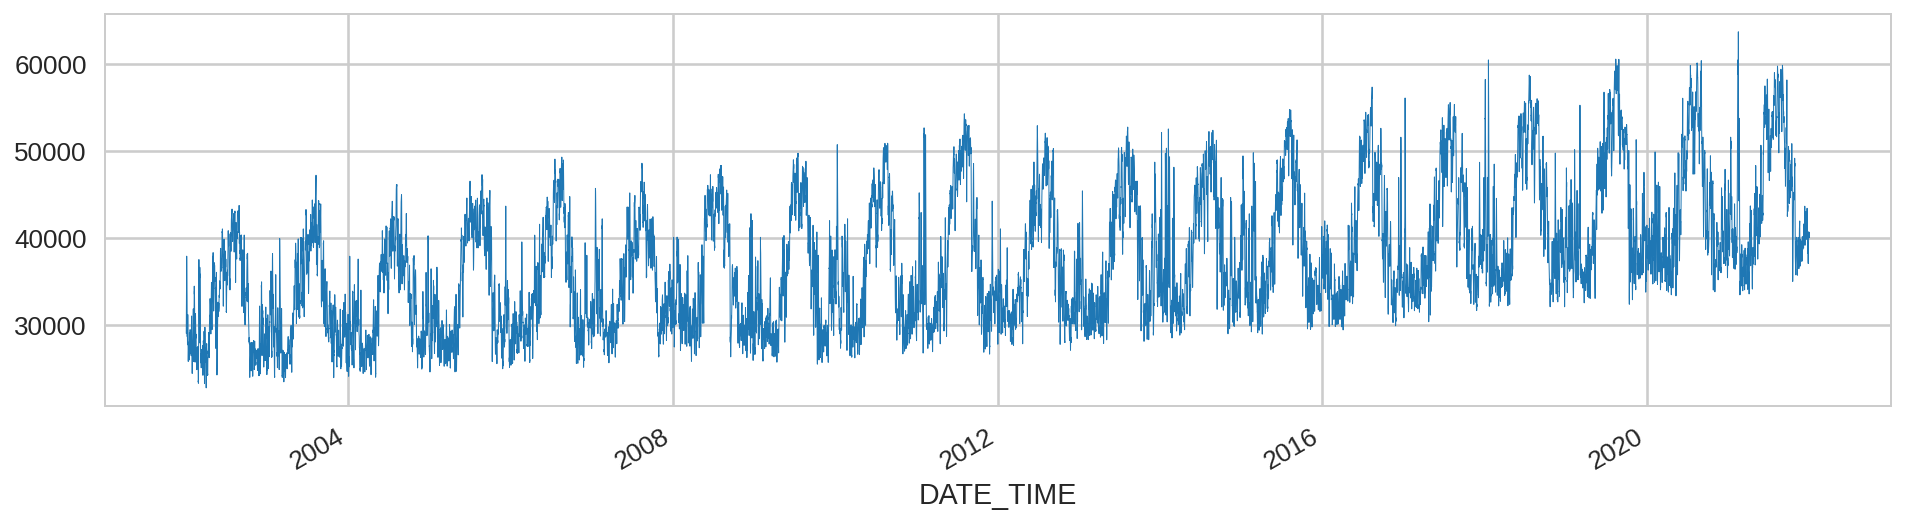

In [11]:
T_d.plot(linewidth=0.5, figsize=(16,4))

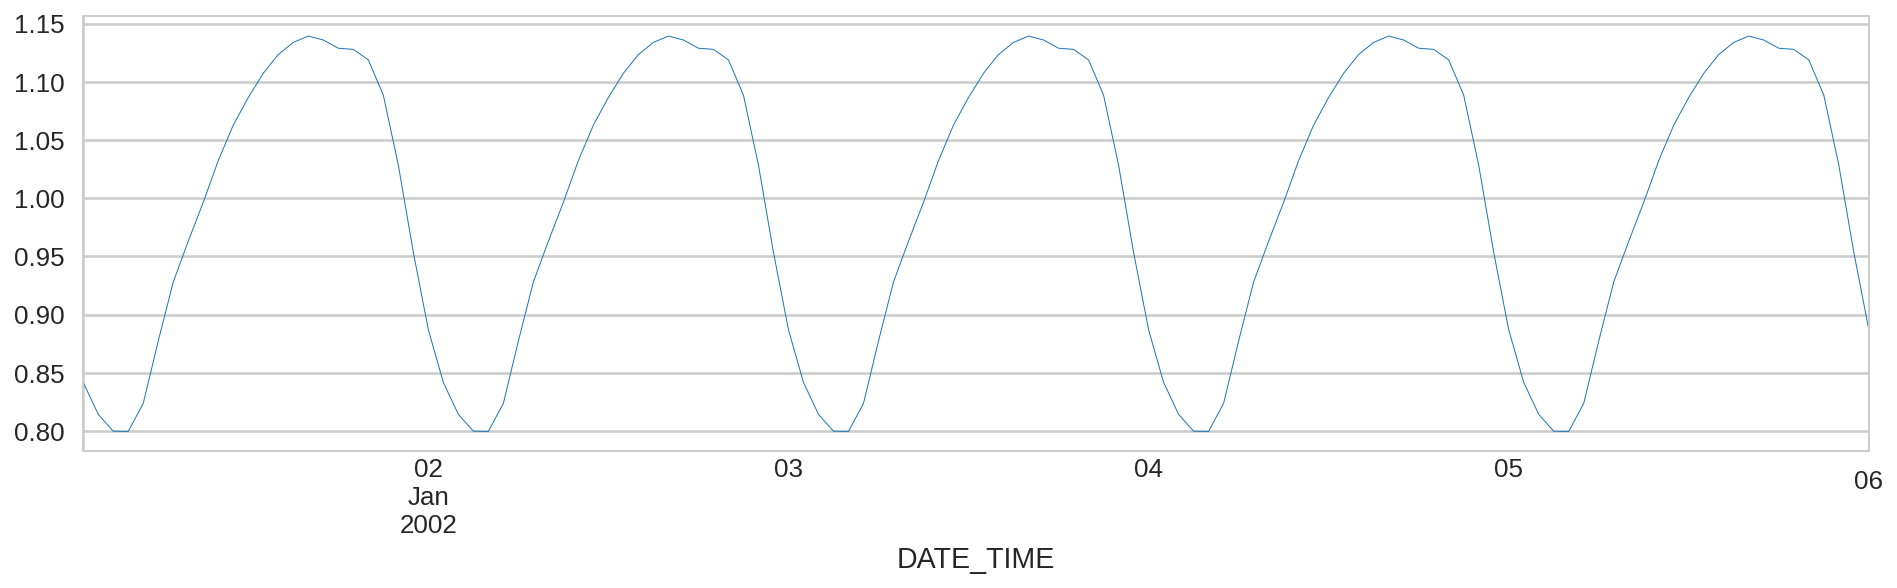

In [12]:
S_d[:24 * 5].plot(figsize=(16,4), linewidth=0.5)

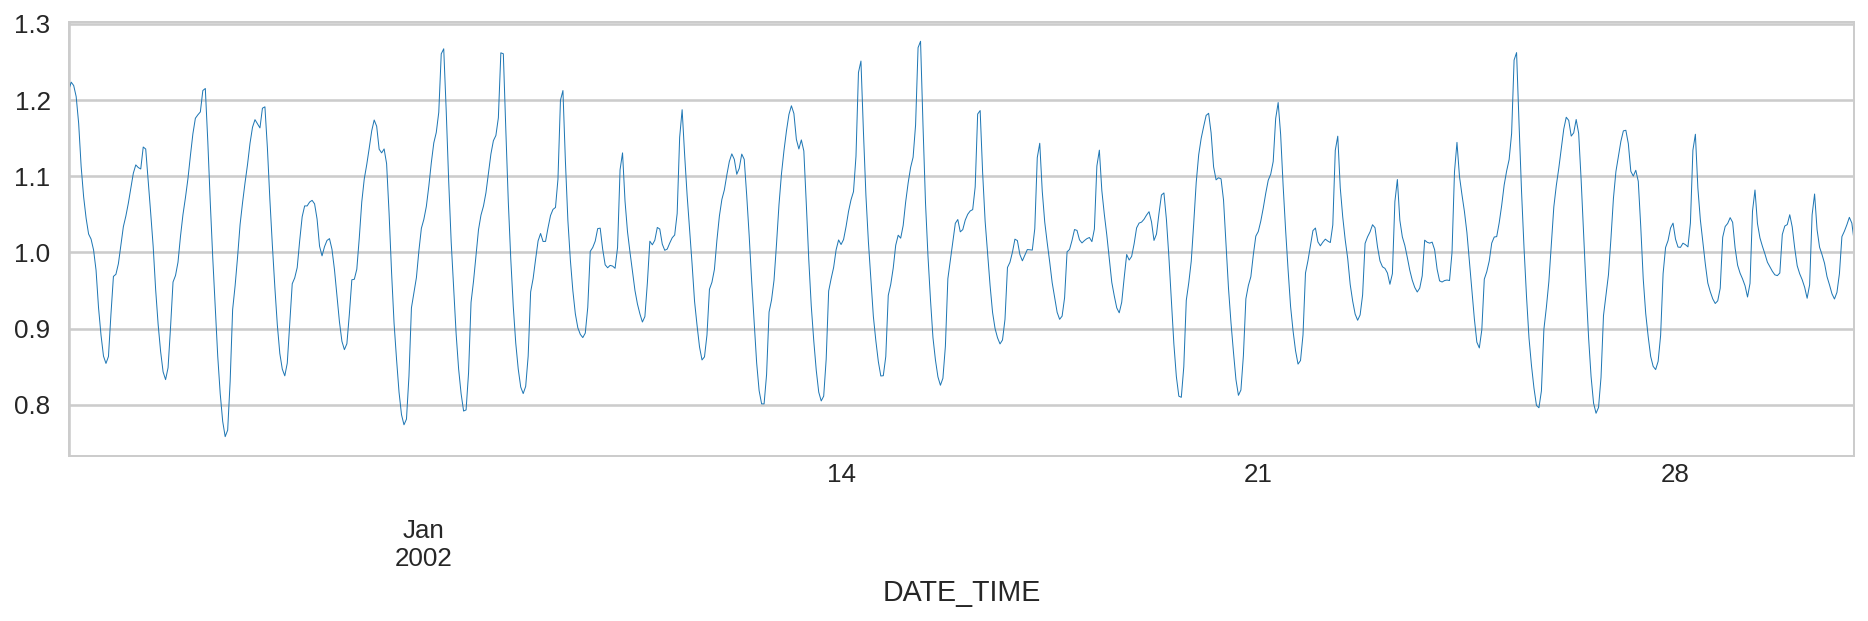

In [13]:
R_d[:24 * 30].plot(figsize=(16,4), linewidth=0.5)

### Analyzing further the $T_d$ Component: Identifying Weekly Patterns

We have extracted three time series (trend, seasonal, residual) from the main time series, after extracting the daily component. 

In [14]:
decompose = seasonal_decompose(T_d, 
                                model='multiplicative', 
                                period=24 * 7, 
                                extrapolate_trend='freq')

T_w, S_w, R_w = decompose.trend, decompose.seasonal, decompose.resid

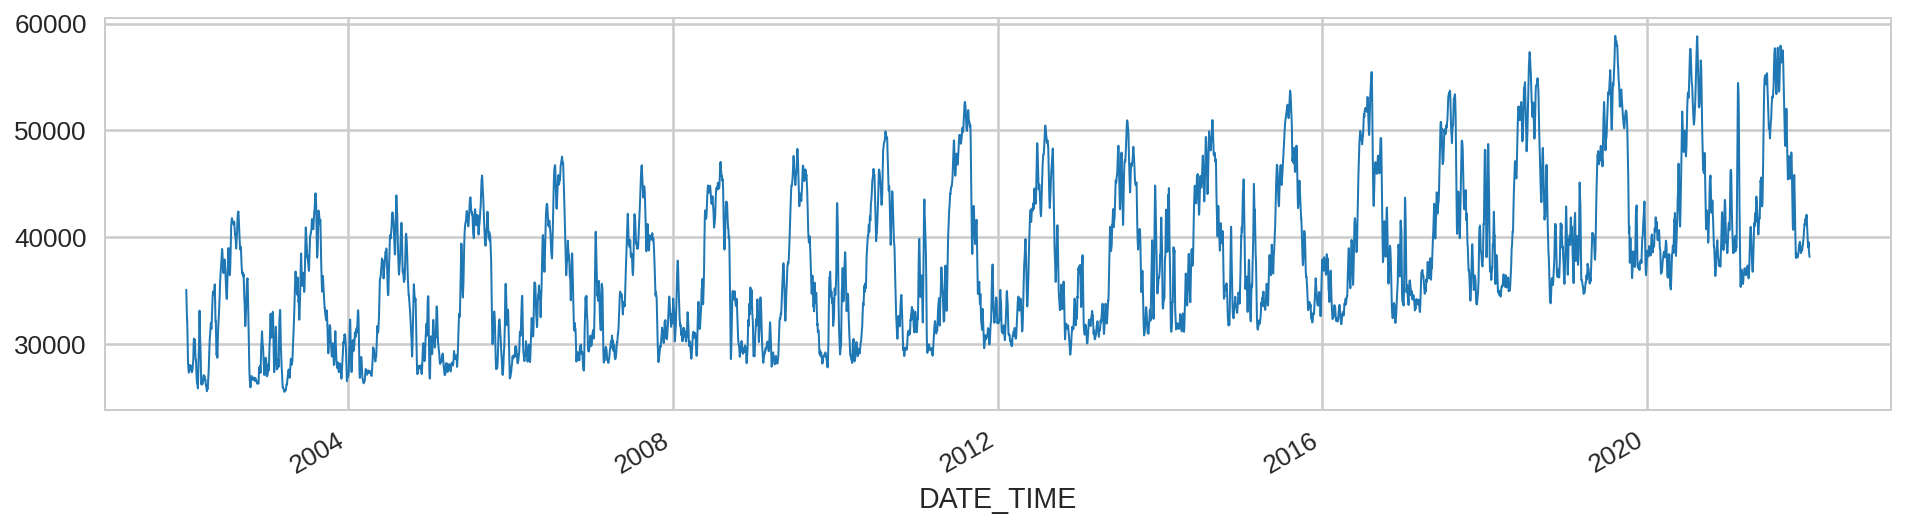

In [15]:
# This is the remaining trend component after removing daily and weekly fluctuations
T_w.plot(figsize=(16,4), linewidth=1)

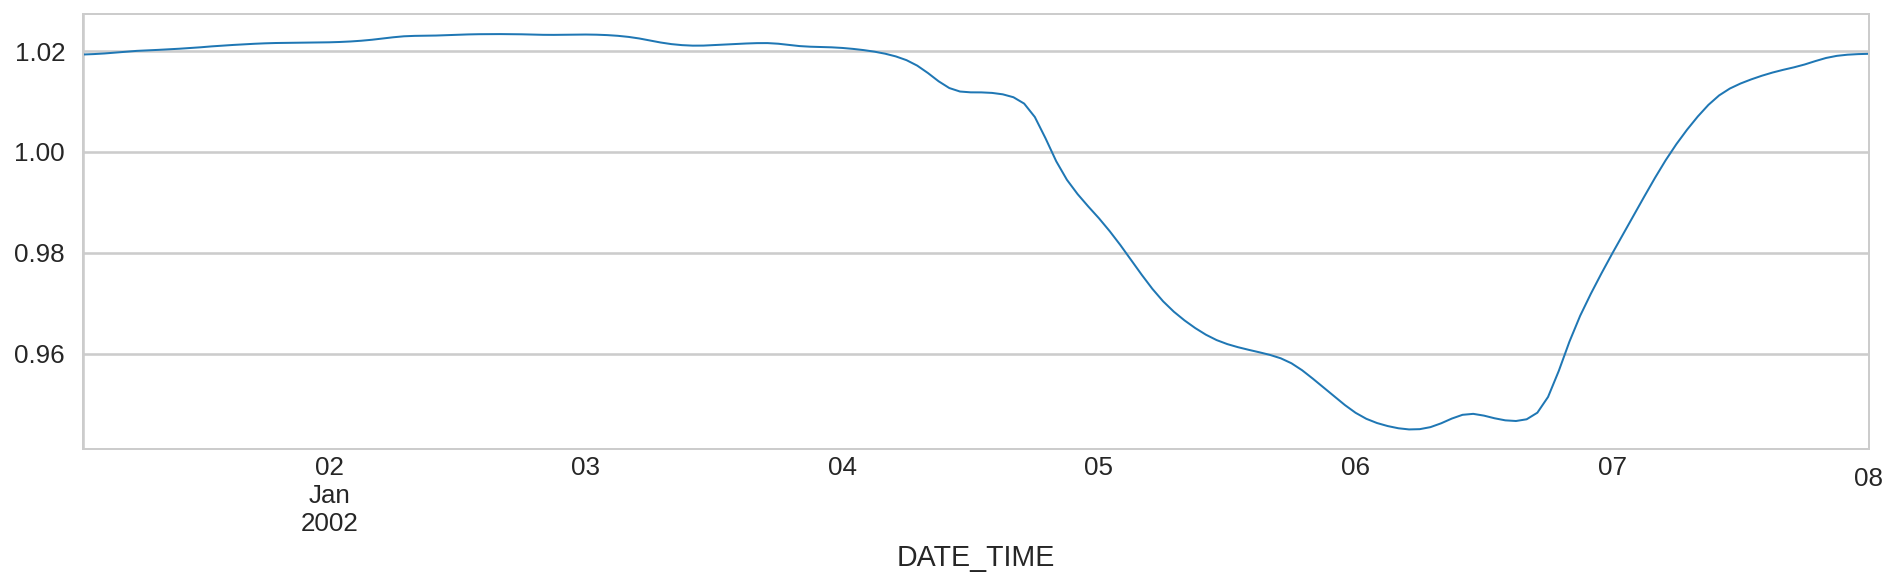

In [16]:
# This shows the weekly seasonality
S_w[0:24*7].plot(figsize=(16,4), linewidth=1)

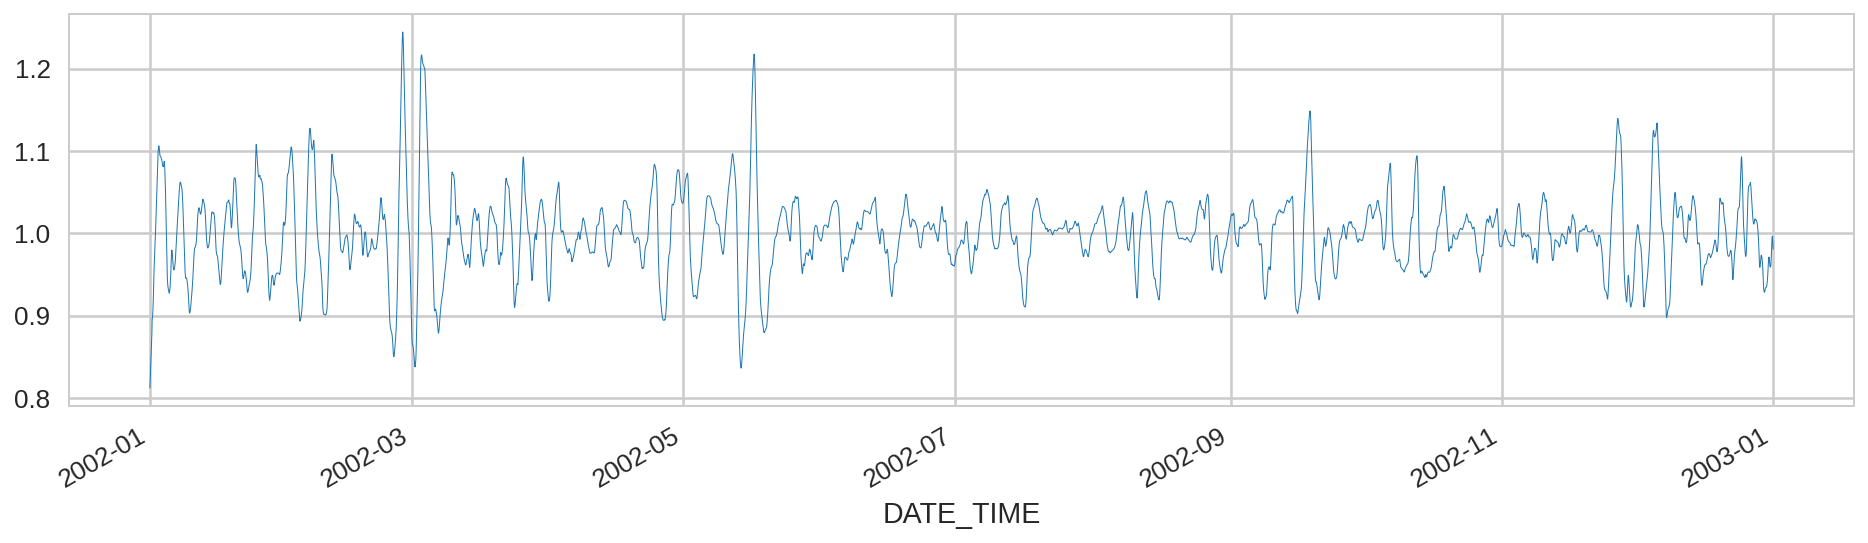

In [17]:
# This shows the residual, after removing the daily and weekly
R_w[:24*365].plot(figsize=(16,4), linewidth=0.5)

### Analyzing further the $T_w$ Component: Identifying yearly Patterns

In [18]:
decompose = seasonal_decompose(T_w, 
                                model='multiplicative', 
                                period=24 * 365, 
                                extrapolate_trend='freq')

T_y, S_y, R_y = decompose.trend, decompose.seasonal, decompose.resid

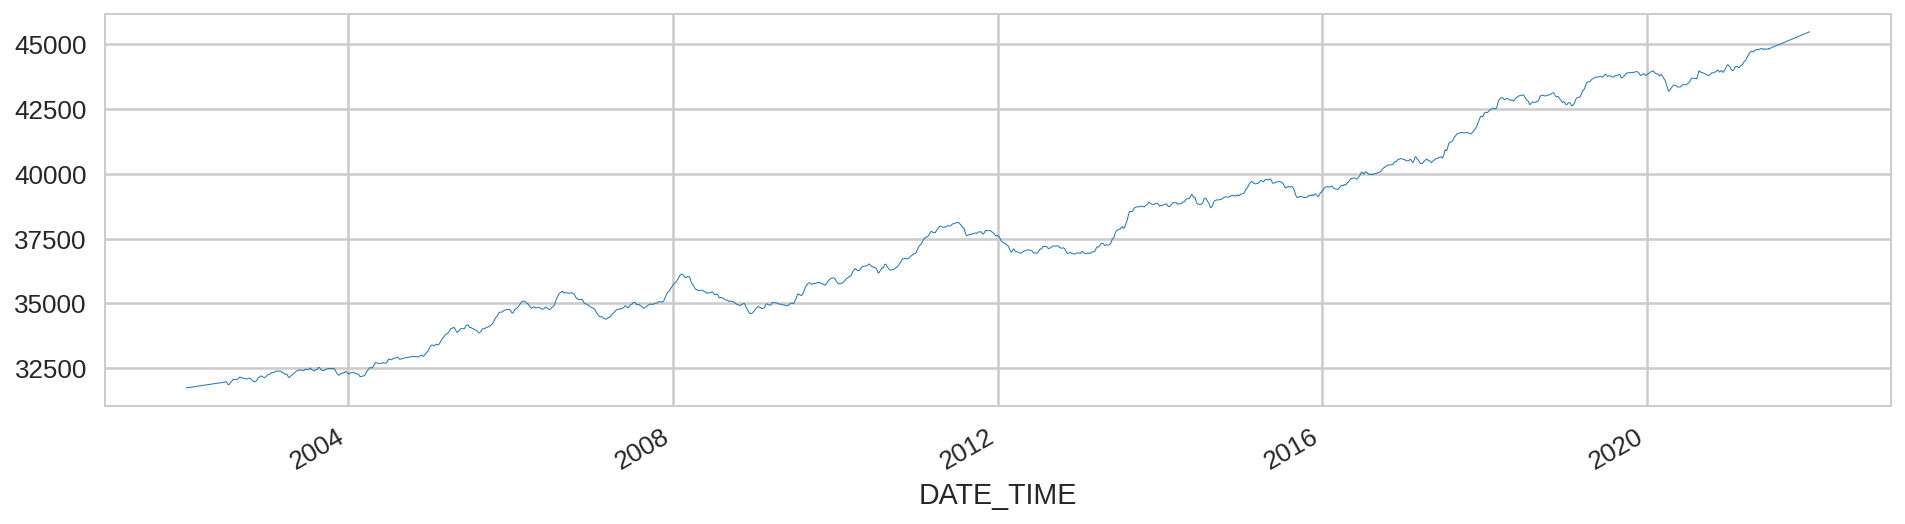

In [19]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot(figsize=(16,4), linewidth=0.5)

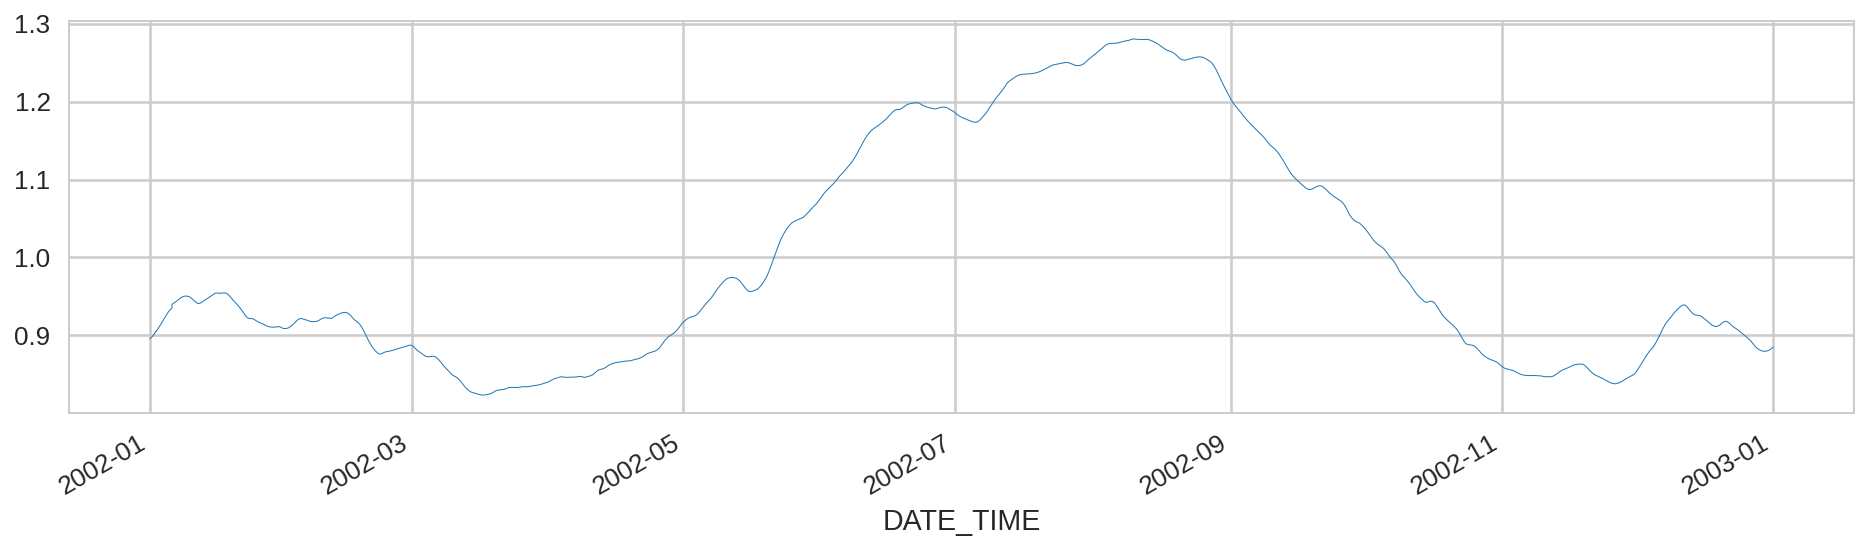

In [20]:
# This shows the yearly seasonality
S_y[:24*365].plot(figsize=(16,4), linewidth=0.5)

## Summary

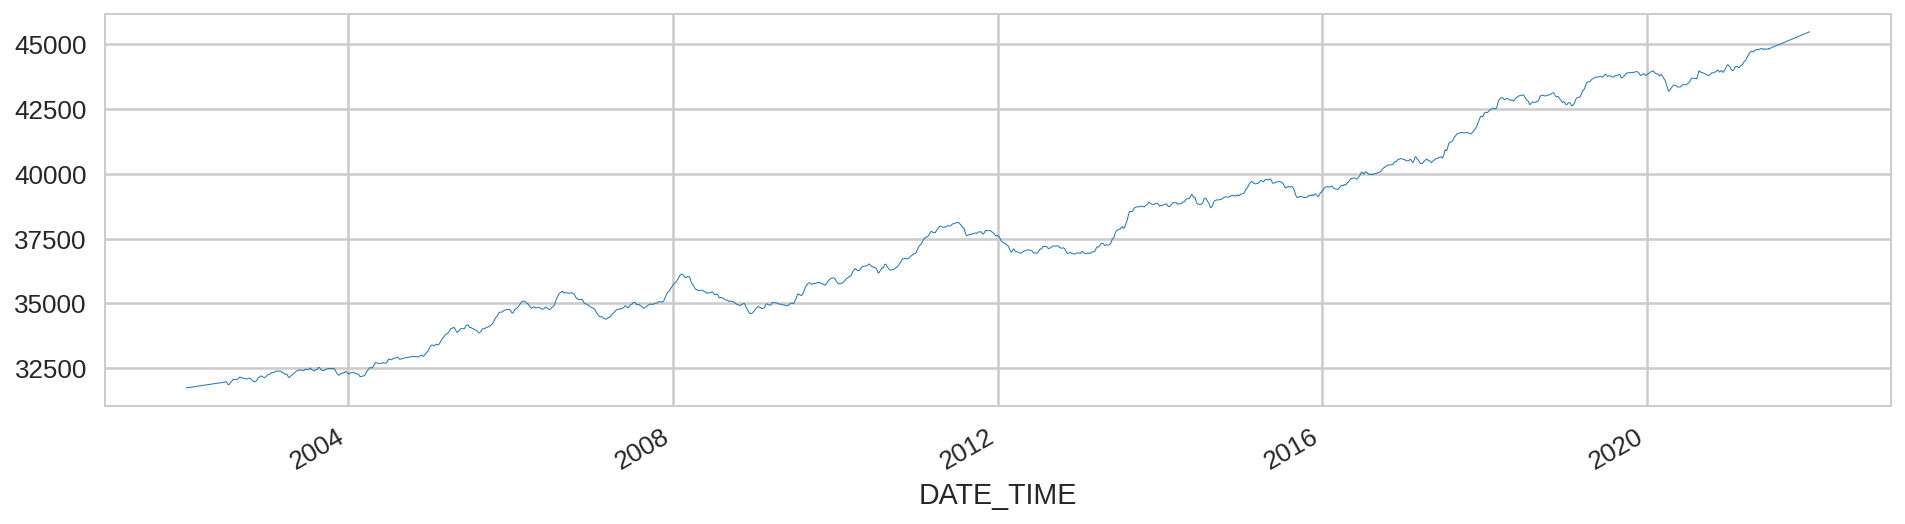

In [21]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot(figsize=(16,4), linewidth=0.5)

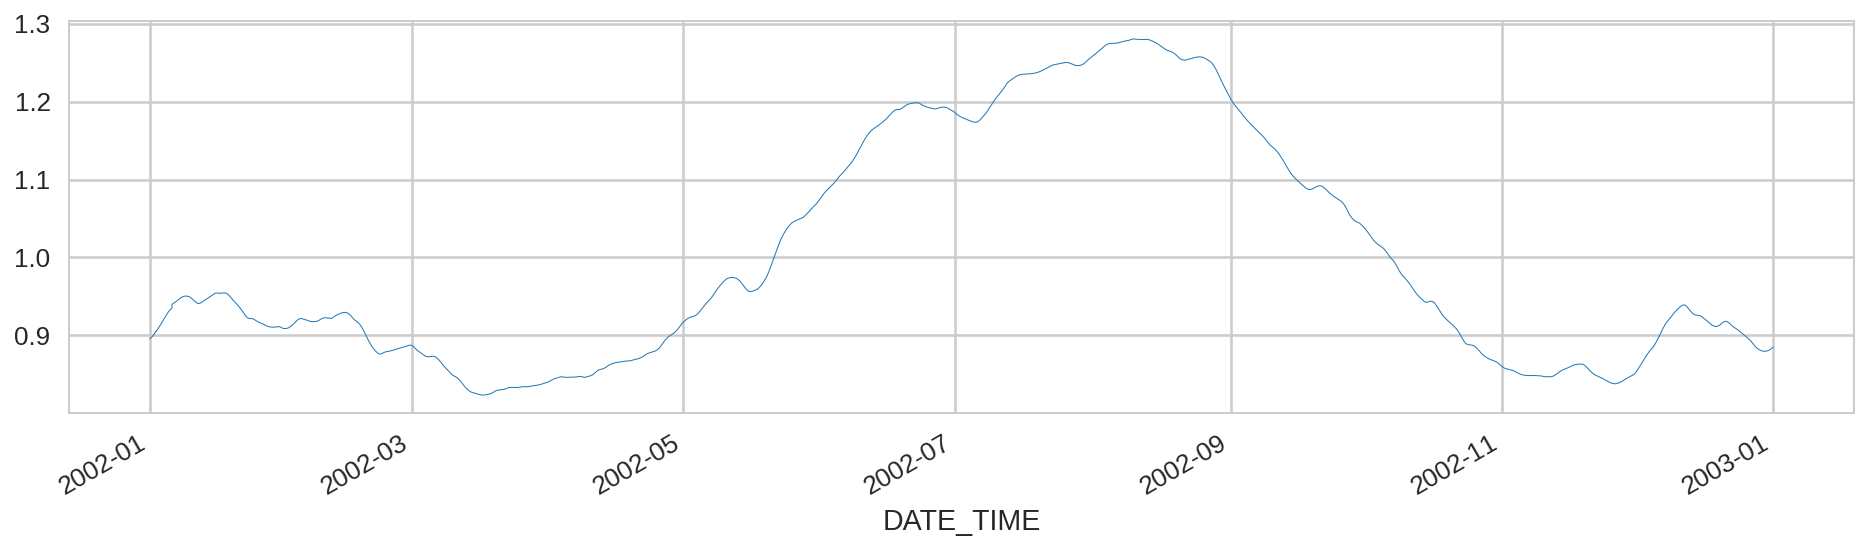

In [22]:
# This shows the yearly seasonality
S_y[:24*365].plot(figsize=(16,4), linewidth=0.5)

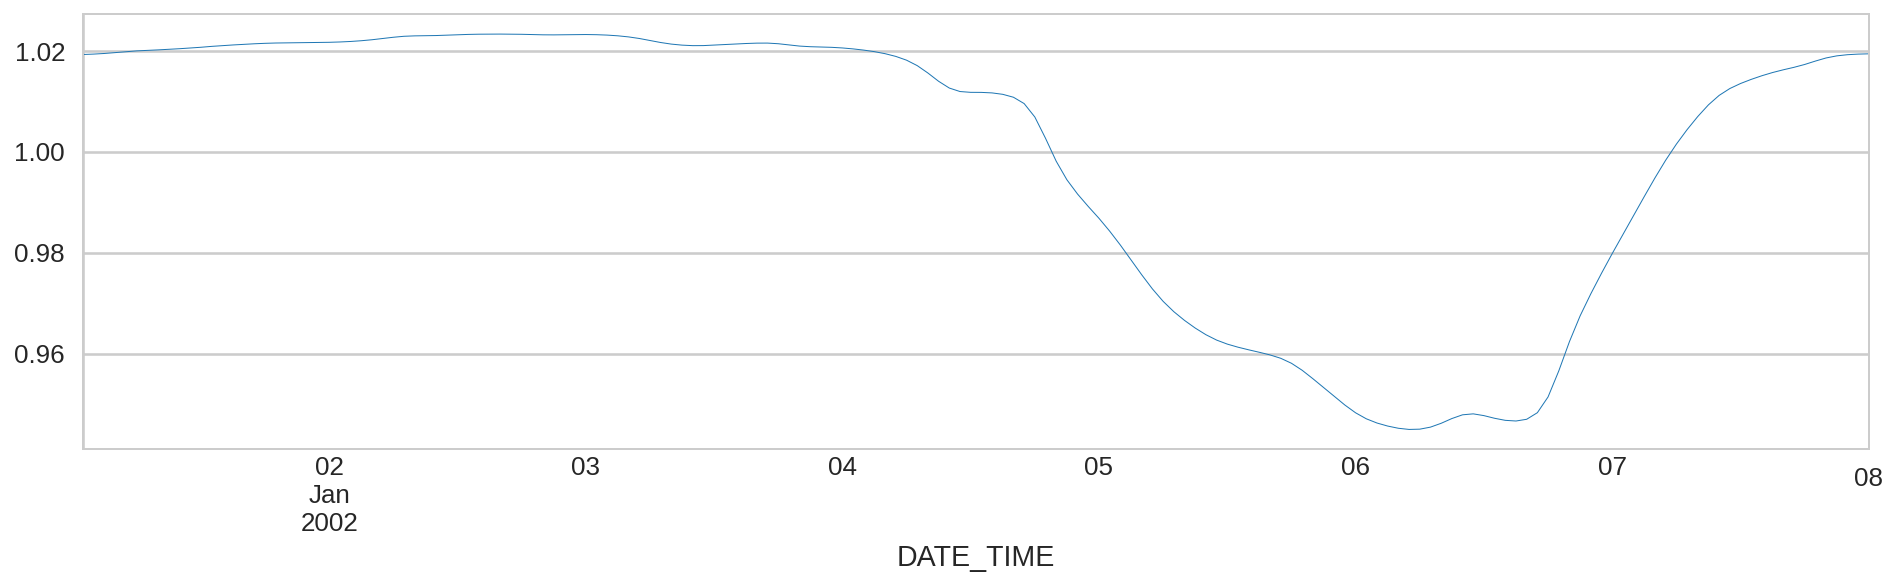

In [23]:
# This shows the weekly seasonality
S_w[0:24*7].plot(figsize=(16,4), linewidth=0.5)

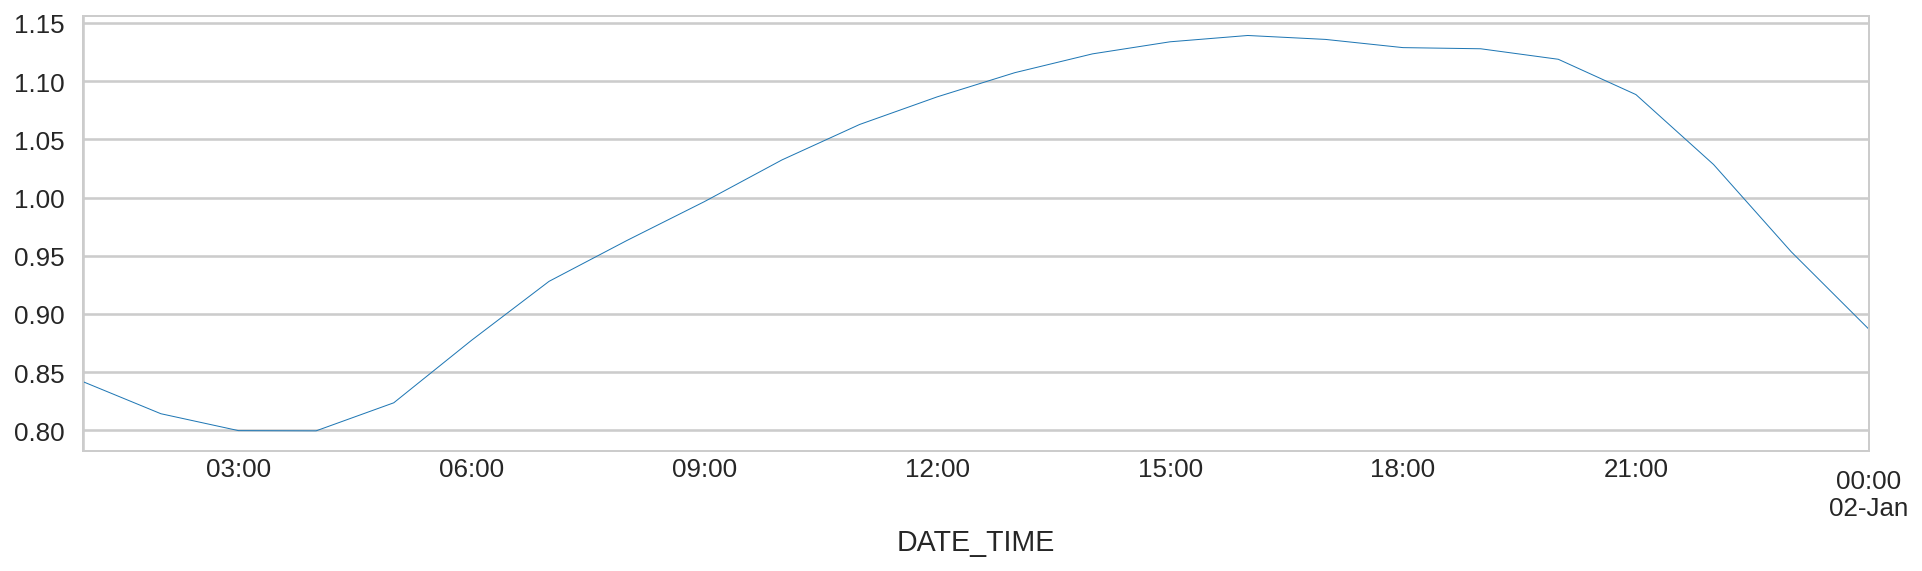

In [24]:
# This shows the daily seasonality
S_d[:24].plot(figsize=(16,4), linewidth=0.5)

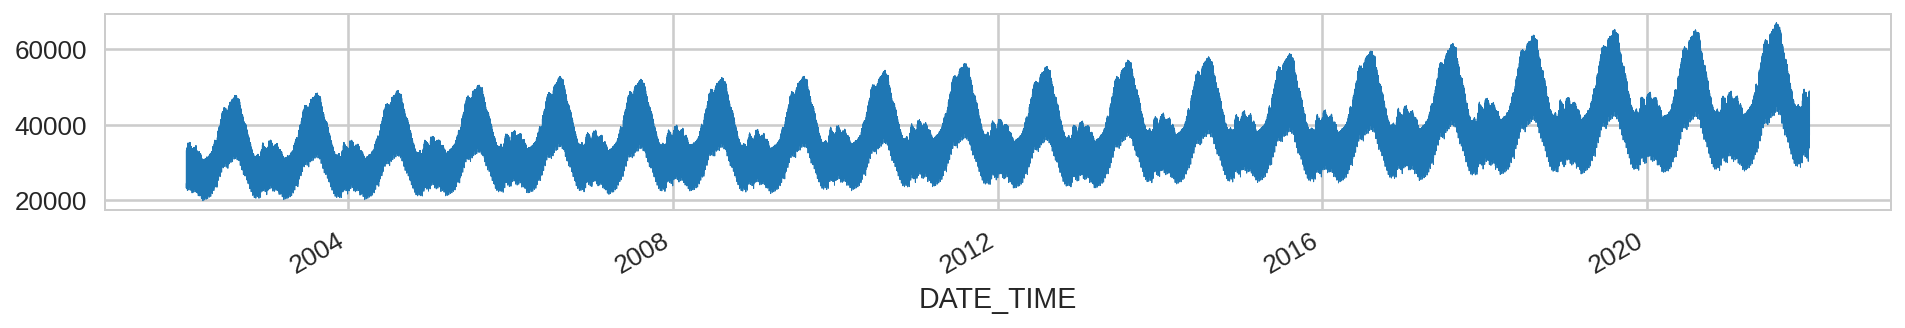

In [25]:
# This is the time series with the overall trend, plus seasonality 
(T_y * S_y * S_w * S_d).plot(figsize=(16,2), linewidth=0.5)

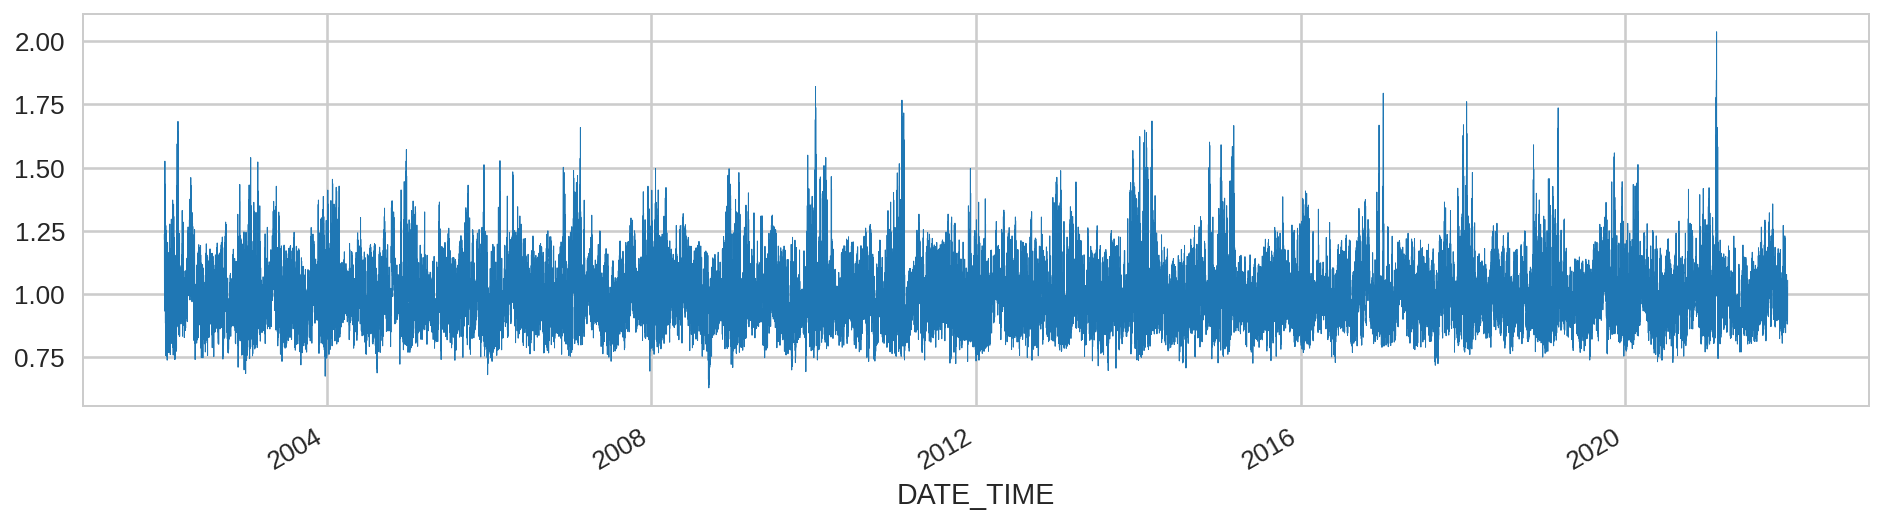

In [26]:
# This is the residual, that is not captured by the trend or seasonality
# When we are modeling, we really talk about forecasting this time
# series, which has been de-trended and de-seasonalized.
( R_y * R_w * R_d ).plot(figsize=(16,4), linewidth=0.5)

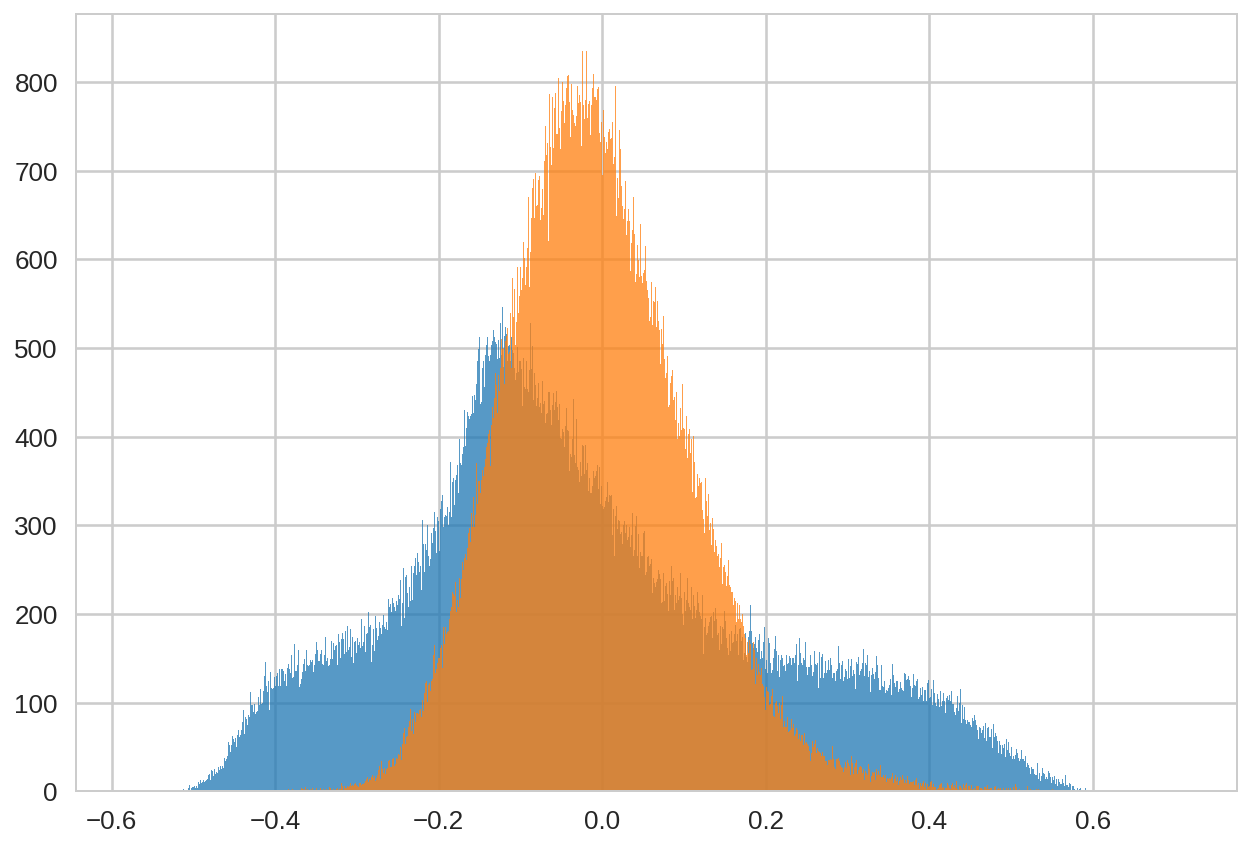

In [27]:
# Plots the histogram of the residuals after removing the trend
np.log(Y / T_y).hist(bins=1000, alpha=0.75)

# Plots the histogram of the residuals after removing trend and seasonality
np.log(Y / (T_y * S_y * S_w * S_d)).hist(bins=1000, alpha=0.75)

## Analyzing further using Prophet

In [28]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [29]:
edf = (
    df
    .resample('1D')
    .sum()
    .reset_index()
    .filter( items = ['DATE_TIME', 'ERCOT'])
    .rename( {'DATE_TIME': 'ds', 'ERCOT': 'y'}, axis="columns" )
)
edf


ds              y
0    2002-01-01  729094.619969
1    2002-01-02  858685.138855
2    2002-01-03  887038.727758
3    2002-01-04  835805.917203
4    2002-01-05  688178.219393
...         ...            ...
7301 2021-12-28  976097.433802
7302 2021-12-29  974899.953573
7303 2021-12-30  961577.567012
7304 2021-12-31  967760.585184
7305 2022-01-01   39270.591873

[7306 rows x 2 columns]

In [30]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(edf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# future = m.make_future_dataframe(periods=365 * 24, freq='H')
future = m.make_future_dataframe(periods=365)
future.tail()

ds
16061 2022-12-31 20:00:00
16062 2022-12-31 21:00:00
16063 2022-12-31 22:00:00
16064 2022-12-31 23:00:00
16065 2023-01-01 00:00:00

In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds           yhat     yhat_lower    yhat_upper
16061 2022-12-31 20:00:00  956336.569360  856600.335252  1.054425e+06
16062 2022-12-31 21:00:00  957865.990557  852997.441278  1.044618e+06
16063 2022-12-31 22:00:00  959638.002234  857296.606605  1.055350e+06
16064 2022-12-31 23:00:00  961642.406693  860245.826030  1.053040e+06
16065 2023-01-01 00:00:00  870901.656488  772349.670744  9.673727e+05

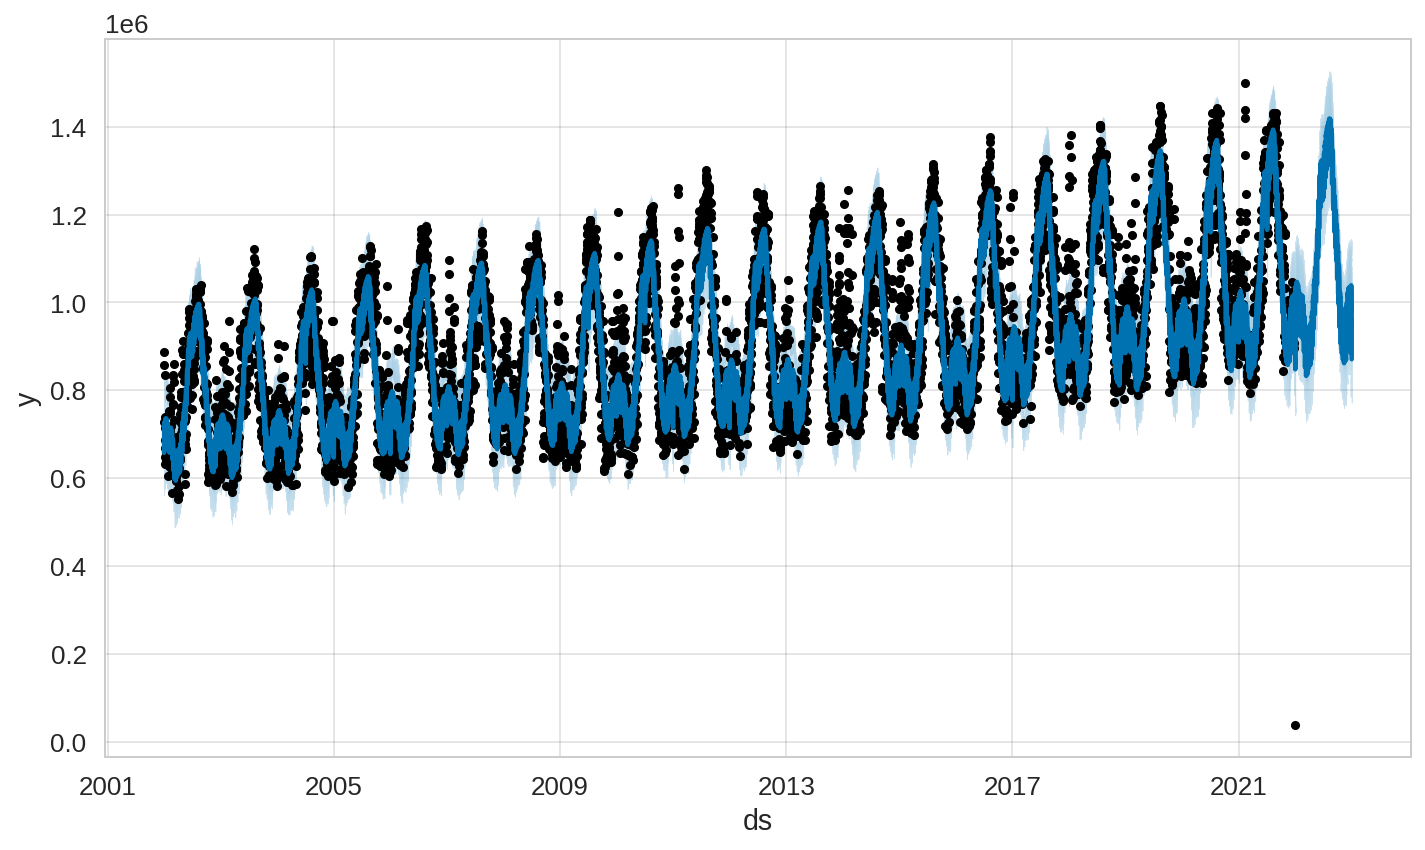

In [33]:
fig1 = m.plot(forecast)

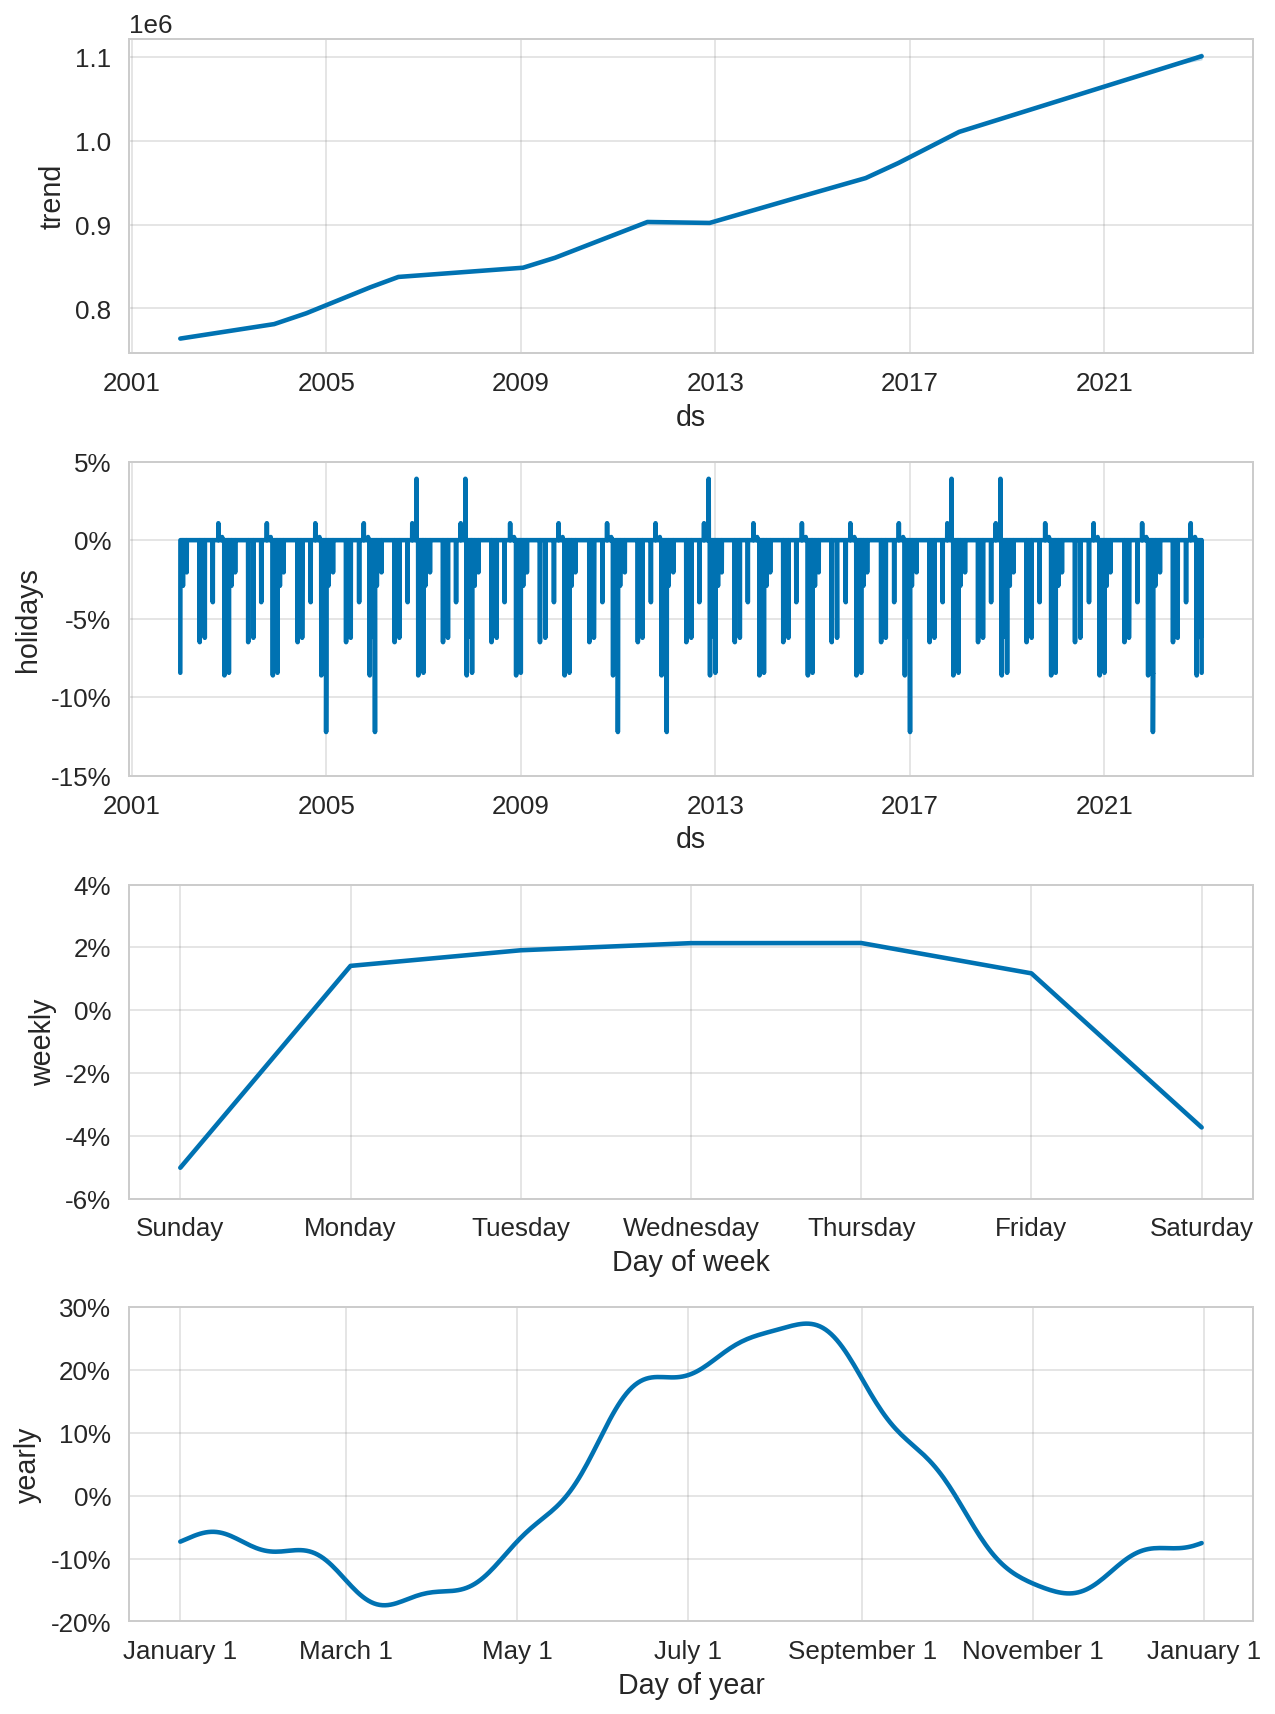

In [34]:
fig2 = m.plot_components(forecast)


In [35]:
plot_plotly(m, forecast)


In [36]:
plot_components_plotly(m, forecast)